<a href="https://colab.research.google.com/github/FadliAhmadYazid/Fxf28/blob/main/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import os
from pathlib import Path
from typing import List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image, UnidentifiedImageError
import random
from tqdm import tqdm
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Load Dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fadliahmad","key":"3021d1423c9540cc1e916e9422e8016f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download joebeachcapital/realwaste
!unzip realwaste.zip

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
Archive:  realwaste.zip
  inflating: realwaste-main/README.md  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_10.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_100.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_101.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_102.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_103.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_104.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_105.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_106.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_107.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_108.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_109.jpg 

## Data Preparation

### List jumlah label dan gambar

In [4]:
def list_image_folders(
    dataset_path: str = "path_datasetmu/",
    check_images: bool = True,
    min_images: int = 1
) -> List[Tuple[str, int]]:
    """
    Mencetak daftar folder dalam direktori dataset dengan informasi lengkap

    Parameters:
    - dataset_path: Path ke direktori dataset
    - check_images: Cek keberadaan file gambar dalam folder
    - min_images: Minimal jumlah gambar untuk ditampilkan

    Returns:
    - List of tuples (folder_name, image_count)
    """
    path = Path(dataset_path)

    # Validasi path secara detail
    if not path.exists():
        raise FileNotFoundError(f"Error: Direktori '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"Error: '{dataset_path}' bukan direktori")

    # Dapatkan daftar folder dengan Path
    folders = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for entry in path.iterdir():
        if entry.is_dir():
            if check_images:
                # Hitung file gambar dalam folder
                image_count = sum(
                    1 for f in entry.iterdir()
                    if f.is_file() and f.suffix.lower() in valid_extensions
                )
            else:
                image_count = -1  # Flag untuk pengecekan disabled

            if image_count >= min_images:
                folders.append((entry.name, image_count))

    # Urutkan berdasarkan nama folder
    folders.sort(key=lambda x: x[0].lower())

    # Tampilkan output formatting
    if not folders:
        print("Tidak ada folder dengan gambar yang ditemukan")
        return []

    print(f"Ditemukan {len(folders)} folder di '{path.absolute()}':")
    max_name_length = max(len(f[0]) for f in folders)
    count_total = 0
    for i, (folder, count) in enumerate(folders, start=1):
        count_info = f"({count} gambar)" if check_images else ""
        print(f"{i:2d}. {folder:{max_name_length}} {count_info}")
        count_total += count

    print(f"Jumlah Gambar {count_total}")
    return folders

In [5]:
if __name__ == "__main__":
    # Contoh penggunaan dengan berbagai opsi
    folders_info = list_image_folders(
        dataset_path="realwaste-main/RealWaste",
        check_images=True,
        min_images=5
    )

    # Untuk mendapatkan daftar folder saja
    folder_names = [f[0] for f in folders_info]
    print("\nDaftar folder tersedia:", folder_names)

Ditemukan 9 folder di '/content/realwaste-main/RealWaste':
 1. Cardboard           (461 gambar)
 2. Food Organics       (411 gambar)
 3. Glass               (420 gambar)
 4. Metal               (790 gambar)
 5. Miscellaneous Trash (495 gambar)
 6. Paper               (500 gambar)
 7. Plastic             (921 gambar)
 8. Textile Trash       (318 gambar)
 9. Vegetation          (436 gambar)
Jumlah Gambar 4752

Daftar folder tersedia: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


### Cek Resolusi

In [6]:
def get_resolution_summary(dataset_path: str = "path_datasetmu/"):
    """
    Menganalisis resolusi gambar dalam semua sub-direktori (kelas)
    dan menghasilkan ringkasan resolusi untuk seluruh dataset.

    Args:
        base_dir (str): Path ke direktori utama dataset.

    Returns:
        None: Mencetak ringkasan resolusi untuk seluruh dataset.
    """
    resolutions = {}
    total_images = 0
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                try:
                    with Image.open(filepath) as img:
                        width, height = img.size
                        resolution = (width, height)
                        resolutions[resolution] = resolutions.get(resolution, 0) + 1
                        total_images += 1
                except Exception as e:
                    print(f"Gagal membuka atau membaca gambar: {filepath} - {e}")

    unique_resolutions = set(resolutions.keys())
    print(f"Resolusi yang ditemukan: {unique_resolutions}")

    if len(unique_resolutions) == 1:
        for res in unique_resolutions:
            print(f"Semua gambar memiliki resolusi yang seragam: {res}")
    else:
        print("Resolusi tidak seragam.")

    print("\nJumlah gambar per resolusi:")
    for resolution, count in sorted(resolutions.items()):
        print(f"Resolusi {resolution}: {count} gambar")

In [7]:
get_resolution_summary(dataset_path="realwaste-main/RealWaste")

Resolusi yang ditemukan: {(524, 524)}
Semua gambar memiliki resolusi yang seragam: (524, 524)

Jumlah gambar per resolusi:
Resolusi (524, 524): 4752 gambar


### Plot Sample

In [8]:
def plot_category_samples(
    dataset_path: str = "path_datasetmu/",
    samples_per_category: int = 5,
    figsize: tuple = (14, 6),
    label_fontsize: int = 12,
    dpi: int = 100
) -> plt.Figure:
    """
    Memvisualisasikan sampel gambar dari setiap kategori dalam dataset

    Parameters:
    - dataset_path: Path ke direktori dataset
    - samples_per_category: Jumlah sampel gambar per kategori yang akan ditampilkan
    - figsize: Ukuran figure matplotlib (width, height)
    - label_fontsize: Ukuran font label kategori
    - dpi: Kualitas output gambar

    Returns:
    - matplotlib Figure object
    """
    path = Path(dataset_path)

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Cari kategori dengan gambar
    categories = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for category_dir in path.iterdir():
        if category_dir.is_dir():
            # Cek file gambar dengan glob
            image_files = list(category_dir.glob('*'))
            if any(f.suffix.lower() in valid_extensions for f in image_files):
                categories.append(category_dir.name)

    categories.sort()

    if not categories:
        print("Tidak ada kategori dengan gambar yang ditemukan")
        return None

    # Setup plot
    n_rows = len(categories)
    n_cols = samples_per_category
    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize[0], figsize[1] + n_rows*0.5),  # Dynamic height
        dpi=dpi,
        gridspec_kw={'wspace':0.05, 'hspace':0.3}
    )

    # Handle single category case
    if n_rows == 1:
        axs = np.expand_dims(axs, axis=0)

    # Hitung margin kiri berdasarkan panjang nama kategori terpanjang
    max_name_length = max(len(cat) for cat in categories)
    plt.subplots_adjust(left=0.2 + 0.01*max_name_length)

    # Plot gambar untuk setiap kategori
    for row_idx, category in enumerate(categories):
        category_path = path / category
        image_files = [
            f for f in category_path.iterdir()
            if f.is_file() and f.suffix.lower() in valid_extensions
        ]

        # Pilih sampel acak dengan jaminan unique
        selected_images = []
        if len(image_files) > 0:
            n_samples = min(samples_per_category, len(image_files))
            selected_indices = np.random.choice(len(image_files), n_samples, replace=False)
            selected_images = [image_files[i] for i in selected_indices]

        # Inisialisasi subplots
        for col_idx in range(n_cols):
            ax = axs[row_idx, col_idx]
            ax.axis('off')
            ax.set_facecolor('#f0f0f0')  # Warna background netral

            # Jika ada gambar yang valid
            if col_idx < len(selected_images):
                try:
                    img = Image.open(selected_images[col_idx])
                    ax.imshow(img)

                    # Tambah border
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_edgecolor('#808080')
                        spine.set_linewidth(0.5)

                except (UnidentifiedImageError, OSError) as e:
                    self._add_error_text(ax, f"Error: {e}")
            else:
                self._add_error_text(ax, "Tidak ada gambar")

        # Tambah label kategori
        axs[row_idx, 0].text(
            -0.3, 0.5,
            category,
            transform=axs[row_idx, 0].transAxes,
            fontsize=label_fontsize,
            fontweight='bold',
            va='center',
            ha='right',
            bbox=dict(
                boxstyle='round',
                facecolor='white',
                edgecolor='#404040',
                alpha=0.8,
                pad=0.3
            )
        )

    plt.show()
    return fig

def _add_error_text(ax, text: str):
    """Helper untuk menambahkan text error di subplot"""
    ax.text(
        0.5, 0.5,
        text,
        ha='center',
        va='center',
        color='red',
        fontsize=8,
        wrap=True
    )
    ax.set_facecolor('#fff0f0')  # Background merah muda untuk error

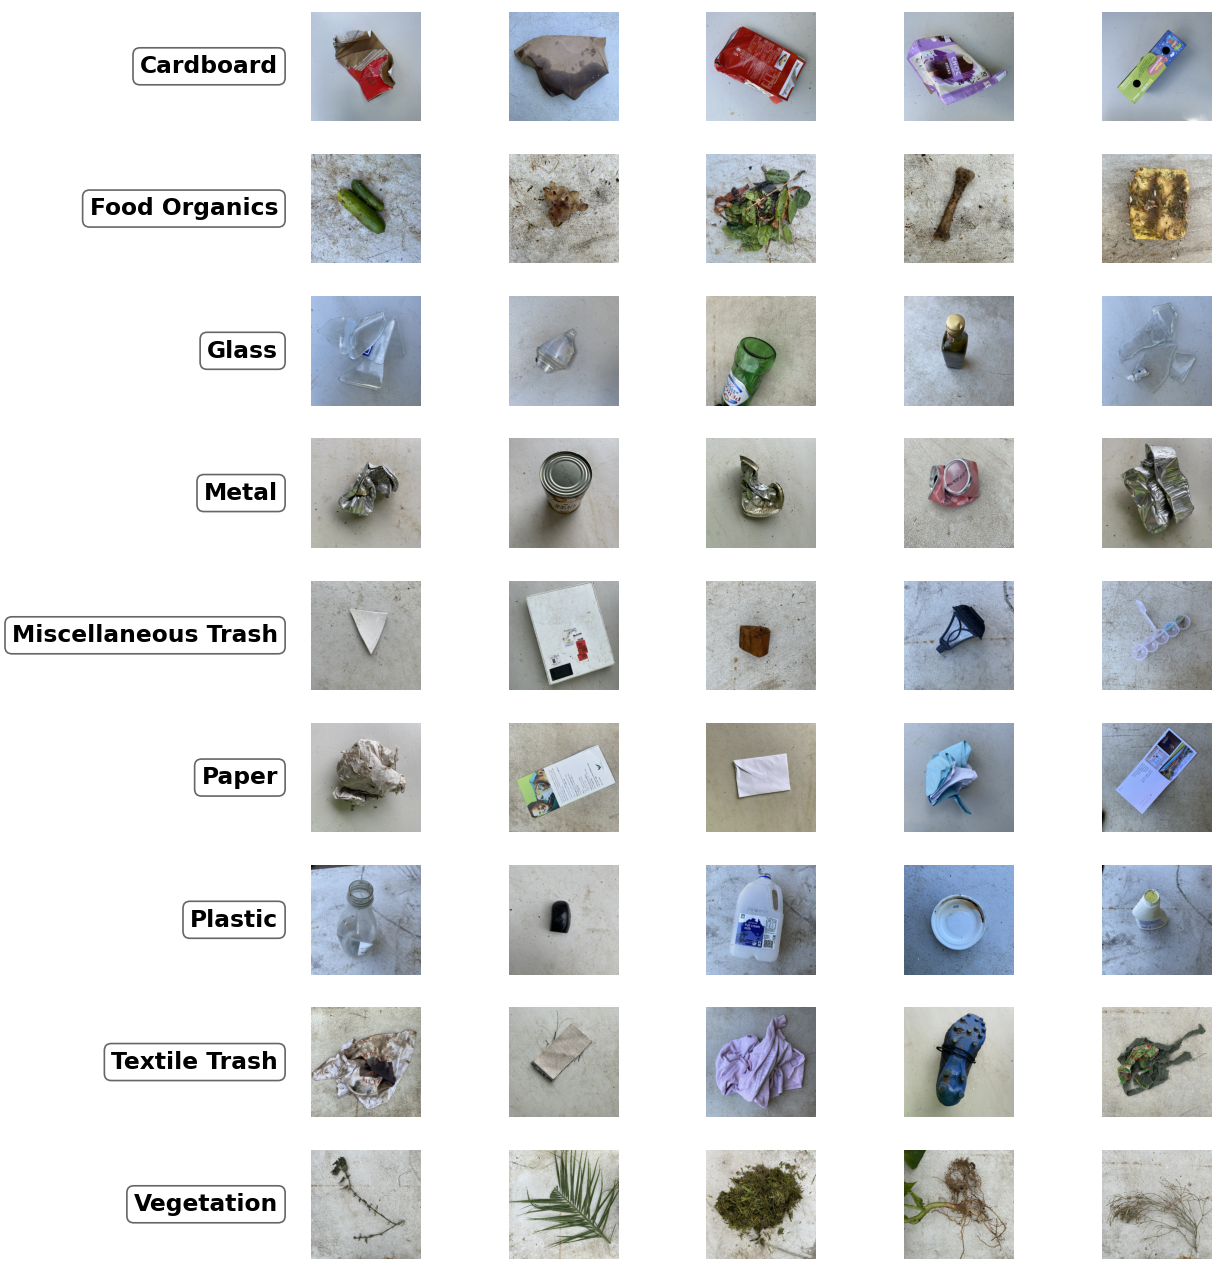

In [9]:
if __name__ == "__main__":
    fig = plot_category_samples(
        dataset_path="realwaste-main/RealWaste",
        samples_per_category=5,
        figsize=(16, 9),
        label_fontsize=14,
        dpi=120
    )

### Distribusi Gambar per Kelas

In [10]:
def analyze_dataset_distribution(dataset_path: str = "path_datasetmy/") -> pd.DataFrame:
    """
    Menganalisis distribusi dataset dan membuat visualisasi

    Parameters:
    - dataset_path: Path ke direktori dataset

    Returns:
    - DataFrame berisi metadata dataset
    """
    path = Path(dataset_path)
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Dataset path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Kumpulkan data dengan pathlib
    image_data = []
    for img_path in path.rglob('*'):
        if img_path.is_file() and img_path.suffix.lower() in valid_extensions:
            relative_path = img_path.relative_to(path)
            label = relative_path.parts[0]  # Ambil direktori level pertama
            image_data.append({
                "path": str(img_path),
                "file_name": img_path.name,
                "label": label,
                "extension": img_path.suffix.lower()
            })

    if not image_data:
        raise ValueError("Tidak ditemukan gambar valid dalam dataset")

    df = pd.DataFrame(image_data)

    # Plot distribusi
    plt.figure(figsize=(14, 8))
    ax = sns.countplot(
        data=df,
        y='label',
        hue='label',
        legend=False,
        order=df['label'].value_counts().index,
        palette='viridis'
    )

    # Tambah annotasi
    total_images = len(df)
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            f'{int(width)}\n({width/total_images:.1%})',
            (width + 0.1, p.get_y() + p.get_height()/2),
            ha='left',
            va='center'
        )

    plt.title(
        f"Distribusi Dataset - Total {len(df)} Gambar ({len(df['label'].unique())} Kategori)",
        fontsize=14,
        pad=20
    )
    plt.xlabel("Jumlah Gambar", labelpad=15)
    plt.ylabel("Kategori", labelpad=15)
    plt.xlim(0, df['label'].value_counts().max() * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df

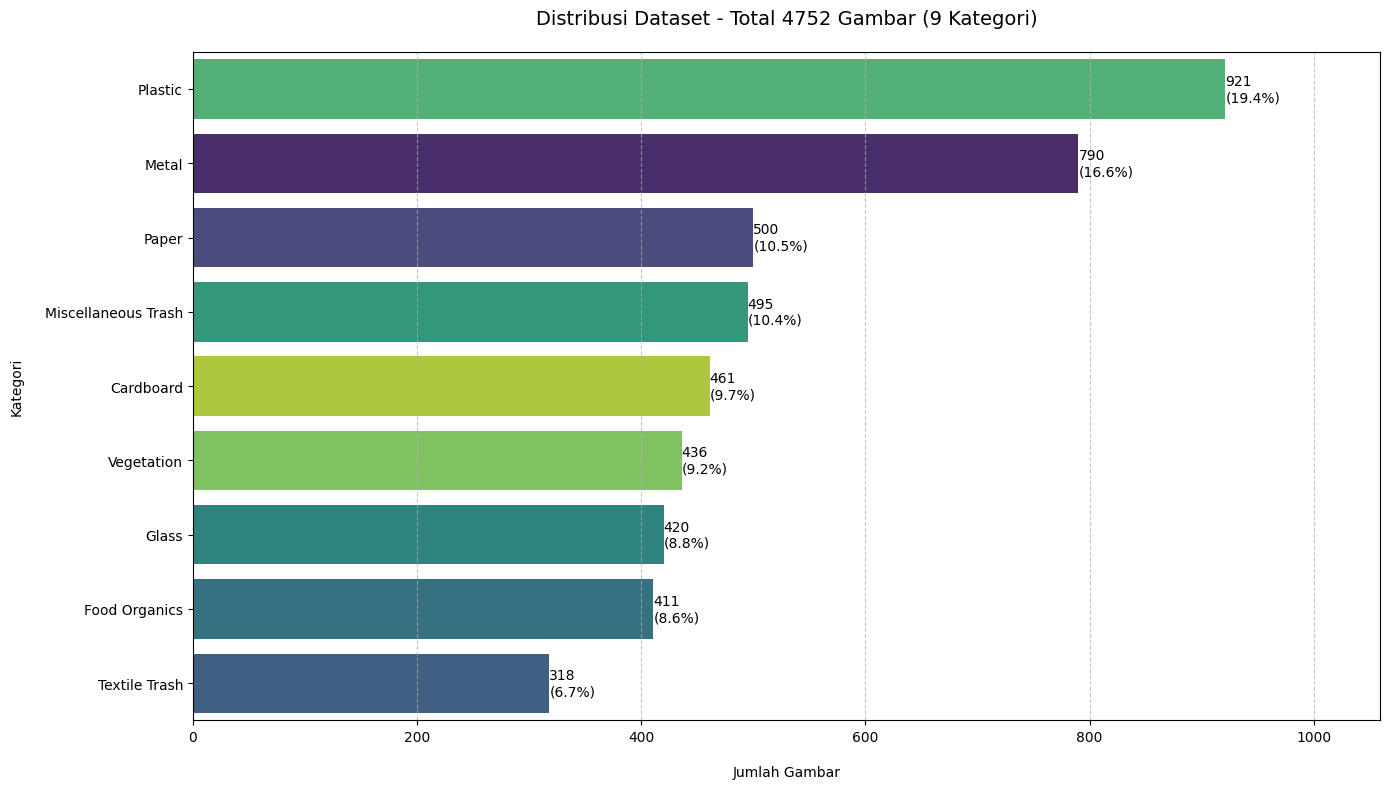


Contoh data:
                                                   path  \
3230   realwaste-main/RealWaste/Plastic/Plastic_890.jpg   
2886  realwaste-main/RealWaste/Miscellaneous Trash/M...   
793        realwaste-main/RealWaste/Paper/Paper_143.jpg   
1214       realwaste-main/RealWaste/Paper/Paper_410.jpg   
1587  realwaste-main/RealWaste/Textile Trash/Textile...   

                        file_name                label extension  
3230              Plastic_890.jpg              Plastic      .jpg  
2886  Miscellaneous Trash_477.jpg  Miscellaneous Trash      .jpg  
793                 Paper_143.jpg                Paper      .jpg  
1214                Paper_410.jpg                Paper      .jpg  
1587        Textile Trash_110.jpg        Textile Trash      .jpg  


In [11]:
if __name__ == "__main__":
    dataset_df = analyze_dataset_distribution(
        dataset_path="realwaste-main/RealWaste/"
    )
    print("\nContoh data:")
    print(dataset_df.sample(5))

## Data Augmentation

Target Augmentasi 1000 gambar per kelas(total 9000)

In [12]:
def augment_and_visualize(
    dataset_path,
    output_path,
    target_per_class=1000,
    img_size=(224, 224),
    show_examples=True,
    n_examples=5
):
    """
    Fungsi untuk augmentasi dataset dan menampilkan hasilnya

    Parameters:
    - dataset_path: Path ke dataset original
    - output_path: Path untuk output hasil augmentasi
    - target_per_class: Target jumlah gambar per kelas
    - img_size: Ukuran gambar output
    - show_examples: Tampilkan contoh hasil augmentasi
    - n_examples: Jumlah contoh yang ditampilkan
    """
    # Setup generator augmentasi
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    # Buat output directory
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)

    # Track augmentation examples
    augmentation_examples = {}

    # Process each class
    class_folders = [d for d in Path(dataset_path).iterdir() if d.is_dir()]
    print(f"Found {len(class_folders)} classes")

    for class_folder in class_folders:
        class_name = class_folder.name
        print(f"Processing {class_name}...")

        # Create output directory for this class
        class_output_dir = output_path / class_name
        class_output_dir.mkdir(exist_ok=True)

        # Get all image files
        valid_extensions = {'.jpg', '.jpeg', '.png'}
        image_files = [
            f for f in class_folder.glob('*')
            if f.is_file() and f.suffix.lower() in valid_extensions
        ]

        original_count = len(image_files)
        print(f"  - Original images: {original_count}")

        # Store examples for visualization
        if show_examples and original_count > 0:
            # Pick a random image for example
            example_img_path = random.choice(image_files)
            orig_img = cv2.imread(str(example_img_path))
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
            orig_img = cv2.resize(orig_img, img_size)

            augmentation_examples[class_name] = {
                'original': orig_img,
                'augmented': []
            }

        # Copy original images
        for img_path in image_files:
            img = cv2.imread(str(img_path))
            img = cv2.resize(img, img_size)
            cv2.imwrite(str(class_output_dir / f"original_{img_path.name}"), img)

        # Skip augmentation if we already have enough images
        if original_count >= target_per_class:
            print(f"  - Class already has {original_count} images, skipping augmentation")
            continue

        # Calculate how many more images we need
        n_to_generate = target_per_class - original_count
        print(f"  - Generating {n_to_generate} augmented images...")

        # Generate augmented images
        counter = 0

        # Process in batches for memory efficiency
        batch_size = min(100, len(image_files))
        for batch_idx in tqdm(range(0, n_to_generate, batch_size)):
            # Randomly select images to augment
            batch_files = np.random.choice(image_files,
                                           min(batch_size, n_to_generate - counter),
                                           replace=True)

            for img_path in batch_files:
                if counter >= n_to_generate:
                    break

                # Read and prepare image
                img = cv2.imread(str(img_path))
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for ImageDataGenerator
                img = np.expand_dims(img, 0)  # Add batch dimension

                # Generate an augmented image
                aug_img = datagen.flow(img, batch_size=1)[0]

                # Convert back to BGR for saving with OpenCV
                aug_img = cv2.cvtColor(aug_img[0].astype(np.uint8), cv2.COLOR_RGB2BGR)
                out_filename = class_output_dir / f"aug_{counter:04d}.jpg"
                cv2.imwrite(str(out_filename), aug_img)

                # Save example for visualization
                if show_examples and counter < n_examples and class_name in augmentation_examples:
                    augmentation_examples[class_name]['augmented'].append(
                        cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
                    )

                counter += 1

        print(f"  - Completed: {original_count + counter} total images")

    # Visualize examples
    if show_examples:
        visualize_augmentations(augmentation_examples, n_examples)

    return augmentation_examples

def visualize_augmentations(examples, n_examples=5):
    """
    Visualisasi hasil augmentasi untuk setiap kelas

    Parameters:
    - examples: Dictionary contoh augmentasi
    - n_examples: Max jumlah contoh per kelas
    """
    n_classes = len(examples)

    # Create figure
    fig, axes = plt.subplots(
        n_classes, n_examples + 1,
        figsize=(3 * (n_examples + 1), 3 * n_classes),
        gridspec_kw={'wspace': 0.05, 'hspace': 0.2}
    )

    # For single class case
    if n_classes == 1:
        axes = np.expand_dims(axes, axis=0)

    # Plot examples
    for i, (class_name, imgs) in enumerate(examples.items()):
        # Plot original
        axes[i, 0].imshow(imgs['original'])
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        # Plot augmented versions
        for j, aug_img in enumerate(imgs['augmented'][:n_examples]):
            axes[i, j+1].imshow(aug_img)
            axes[i, j+1].set_title(f"Aug {j+1}")
            axes[i, j+1].axis('off')

        # If we have fewer than n_examples, fill with empty plots
        for j in range(len(imgs['augmented']), n_examples):
            axes[i, j+1].axis('off')

        # Add class label on the left
        axes[i, 0].text(
            -0.5, 0.5, class_name,
            rotation=90,
            horizontalalignment='center',
            verticalalignment='center',
            transform=axes[i, 0].transAxes,
            fontsize=12,
            fontweight='bold'
        )

    plt.suptitle("Original vs Augmented Images", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

Found 9 classes
Processing Metal...
  - Original images: 790
  - Generating 210 augmented images...


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


  - Completed: 1000 total images
Processing Paper...
  - Original images: 500
  - Generating 500 augmented images...


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


  - Completed: 1000 total images
Processing Textile Trash...
  - Original images: 318
  - Generating 682 augmented images...


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


  - Completed: 1000 total images
Processing Food Organics...
  - Original images: 411
  - Generating 589 augmented images...


100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


  - Completed: 1000 total images
Processing Glass...
  - Original images: 420
  - Generating 580 augmented images...


100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


  - Completed: 1000 total images
Processing Miscellaneous Trash...
  - Original images: 495
  - Generating 505 augmented images...


100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


  - Completed: 1000 total images
Processing Plastic...
  - Original images: 921
  - Generating 79 augmented images...


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


  - Completed: 1000 total images
Processing Vegetation...
  - Original images: 436
  - Generating 564 augmented images...


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


  - Completed: 1000 total images
Processing Cardboard...
  - Original images: 461
  - Generating 539 augmented images...


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


  - Completed: 1000 total images


<ipython-input-12-a25242a81967>:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


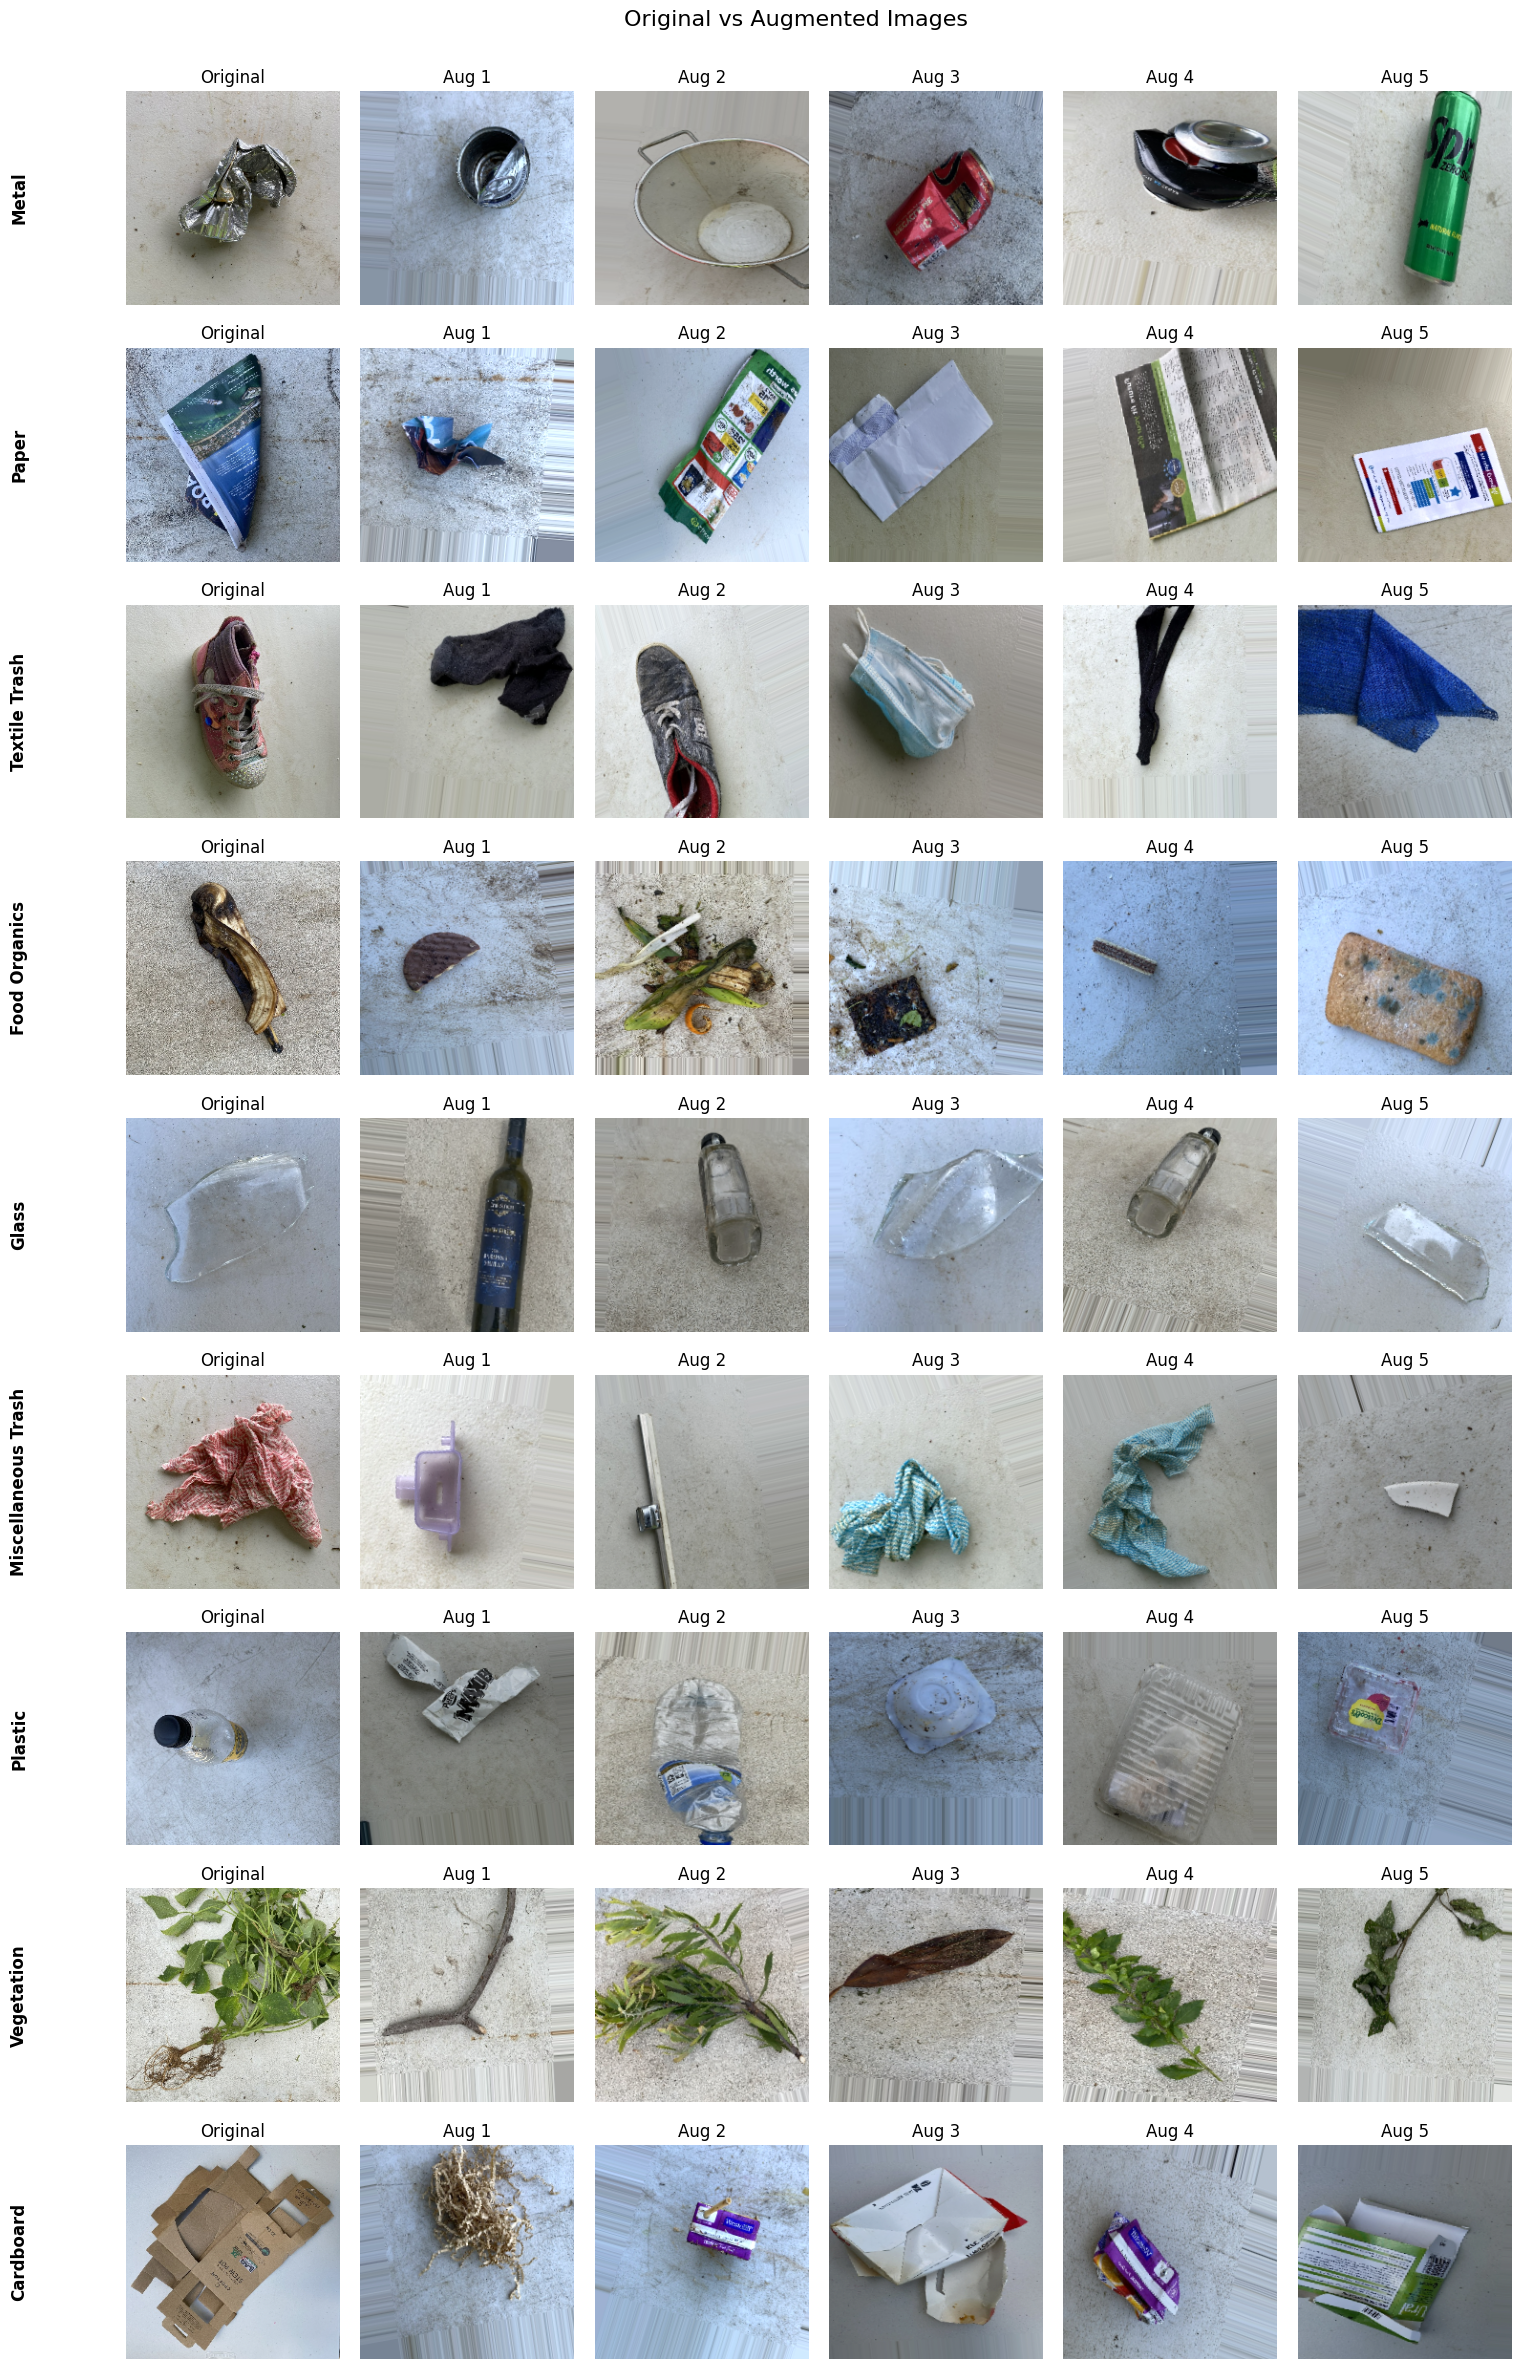


Summary of Augmentation:
Cardboard: 461 original + 539 augmented = 1000 total
Food Organics: 411 original + 589 augmented = 1000 total
Glass: 420 original + 580 augmented = 1000 total
Metal: 790 original + 210 augmented = 1000 total
Miscellaneous Trash: 495 original + 505 augmented = 1000 total
Paper: 500 original + 500 augmented = 1000 total
Plastic: 921 original + 79 augmented = 1000 total
Textile Trash: 318 original + 682 augmented = 1000 total
Vegetation: 436 original + 564 augmented = 1000 total


In [13]:
# Contoh penggunaan
if __name__ == "__main__":
    # Dataset path
    dataset_path = "realwaste-main/RealWaste"
    output_path = "augmented_dataset"

    # Proses augmentasi dan visualisasi
    aug_examples = augment_and_visualize(
        dataset_path=dataset_path,
        output_path=output_path,
        target_per_class=1000,  # Target 1000 gambar per kelas
        img_size=(224, 224),
        show_examples=True,
        n_examples=5
    )

    # Tampilkan jumlah gambar sebelum dan sesudah augmentasi
    print("\nSummary of Augmentation:")
    for class_name in sorted(Path(output_path).glob('*')):
        if class_name.is_dir():
            n_images = len(list(class_name.glob('*.jpg')))
            original = len(list(class_name.glob('original_*.jpg')))
            augmented = n_images - original

            print(f"{class_name.name}: {original} original + {augmented} augmented = {n_images} total")

## Data Preparation

Data splitting train val test

## Pemodelan

1. ML Klasik
2. Computer Vision

### Evaluasi

## Konversi Model

## Inferensi